In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.scipy as jsp

from infiniteDoob.landmarks import LandmarkManifold
from infiniteDoob import metric, Eulerian
from infiniteDoob.utils import integrate_sde, integrator_ito

In [3]:
key = jax.random.PRNGKey(0)

In [4]:
def downsample_shape(M, key=None, random=False):
    if random:
        assert key is not None
        phis = jax.random.uniform(key, (M.N,), minval=0., maxval=2.0*jnp.pi)
    else:
        phis = jnp.linspace(0., 2.0*jnp.pi, M.N, endpoint=False)
        phis = jnp.sort(phis)
    return M.coords(jnp.vstack([jnp.cos(phis),
                                jnp.sin(phis)]).T.ravel())

def tile(x,N):
    try:
        return jnp.tile(x, (N,)+(1,)*x.ndim)
    except AttributeError:
        try:
            return jnp.tile(x, N)
        except TypeError:
            return tuple([tile(y, N) for y in x])

In [5]:
N_LANDMARKS = 64
DOMAIN_SIZE = 3.0
DOMAIN_RESOLUTION = 64
KERNEL_ALPHA = 0.5
KERNEL_SIGMA = 0.1
KERNEL_RANGE = 2.0 * KERNEL_SIGMA

T = 1.0
N_STEPS = 100

M = LandmarkManifold(N=N_LANDMARKS, m=2)
metric.initialize(M)
Eulerian.initialize(M)

PIXEL_SIZE = DOMAIN_SIZE / DOMAIN_RESOLUTION
KERNEL_RANGE_IN_PIXELS = KERNEL_RANGE / PIXEL_SIZE
KERNEL_DIM_IN_PIXELS = int(2 * KERNEL_RANGE_IN_PIXELS) + 1
print(f"Kernel Dimension: {KERNEL_DIM_IN_PIXELS} x {KERNEL_DIM_IN_PIXELS}")
KERNEL_BASIS_IN_PIXELS = jnp.linspace(-KERNEL_RANGE_IN_PIXELS, KERNEL_RANGE_IN_PIXELS, KERNEL_DIM_IN_PIXELS) if KERNEL_DIM_IN_PIXELS > 1 else jnp.array([0.])

make_square = lambda Q: Q.reshape((int(jnp.sqrt(Q.size)), int(jnp.sqrt(Q.size))))
k_Q = lambda q, alpha, sigma: 0.5 * (alpha**2) * (sigma**2) * jnp.pi * jnp.exp(-0.5 * jnp.sum(jnp.square(q), 2) / (sigma**2))
k_Q_q = lambda q1, q2, alpha, sigma: k_Q(q=q1.reshape((-1, M.m))[:, jnp.newaxis, :] - q2.reshape((-1, M.m))[jnp.newaxis, :, :], alpha=alpha, sigma=sigma)  
Q = lambda q, alpha, sigma: make_square(Q=jnp.einsum('ij,kl->ikjl', k_Q_q(q, q, alpha, sigma), jnp.eye(M.m)))                                               

gaussian1d = lambda basis, std: jnp.exp(-1.0 * (basis / std)**2)
k_Q_half = lambda alpha, sigma: (alpha * PIXEL_SIZE) * gaussian1d(basis=KERNEL_BASIS_IN_PIXELS, std=sigma/PIXEL_SIZE) * gaussian1d(basis=KERNEL_BASIS_IN_PIXELS[:, None], std=sigma/PIXEL_SIZE) 
dWs = lambda total_t, n_steps, n_batches, key: jnp.sqrt(total_t / n_steps) * jax.random.normal(key=key, shape=(n_steps, n_batches, DOMAIN_RESOLUTION, DOMAIN_RESOLUTION, M.m))
dts = lambda total_t, n_steps: jnp.array([total_t / n_steps] * n_steps)                                                                      

coords_to_pixel = lambda q: (q - (-DOMAIN_SIZE/2.0)) / PIXEL_SIZE

Q_half_dWs = jax.vmap(
    fun=jax.vmap(                                                                                                                                                                     
            fun=jax.vmap(
                fun=lambda alpha, sigma, _dWs: jsp.signal.convolve(_dWs, k_Q_half(alpha=alpha, sigma=sigma), mode='same'),
                in_axes=(None, None, 2),
                out_axes=2
            ),
            in_axes=(None, None, 0),
            out_axes=0
        ),
    in_axes=(None, None, 1),
    out_axes=1
)

interpolate = jax.vmap(
        fun=lambda _Q_half_dW, q: jsp.ndimage.map_coordinates(_Q_half_dW, coordinates=coords_to_pixel(q).T, order=1),
        in_axes=(2, None),
        out_axes=1
    )

def inf_noise_eulerian_sde(c, y):
    _, q, _ = c
    _, _Q_half_dW = y

    X = None
    det = jnp.zeros_like(q)
    sto = interpolate(_Q_half_dW, q.reshape((-1, M.m))).ravel()
    return (det, sto, X)

def inf_noise_eulerian_sde_product(c, y):
    t, q, chart = c
    dt, _Q_half_dW = y

    (det, sto, X) = jax.vmap(
        fun=lambda q, chart, _Q_half_dW: inf_noise_eulerian_sde(c=(t, q, chart), y=(dt, _Q_half_dW)),
        in_axes=0
    )(q, chart, _Q_half_dW)

    return (det, sto, X)

inf_noise_eulerian_dynamics = jax.jit(lambda q, alpha, sigma, _dts, _dWs: integrate_sde(sde=inf_noise_eulerian_sde_product,
                                                                                       integrator=integrator_ito,
                                                                                       chart_update=None,
                                                                                       x=q[0],
                                                                                       chart=q[1],
                                                                                       dts=_dts,
                                                                                       dWs=Q_half_dWs(alpha, sigma, _dWs))[0:3])

Kernel Dimension: 9 x 9


In [20]:
key, _ = jax.random.split(key)
N_BATCHES = 128
_dWs = dWs(total_t=T, n_steps=N_STEPS, key=key, n_batches=N_BATCHES)
_dts = dts(total_t=T, n_steps=N_STEPS)
q0 = downsample_shape(M, key=key, random=False)
%time (tss, qss, chartss) = inf_noise_eulerian_dynamics(tile(q0, N_BATCHES), KERNEL_ALPHA, KERNEL_SIGMA, _dts, _dWs)

CPU times: user 5.59 ms, sys: 0 ns, total: 5.59 ms
Wall time: 5.49 ms


In [22]:
qss = jax.device_put(qss, device=jax.devices('cpu')[0])
chartss = jax.device_put(chartss, device=jax.devices('cpu')[0])

In [24]:
# this part of code should be run on CPU
M.plot()
M.plot_path(zip(qss[:, 1, :], chartss[:, 1, :]), color='silver', color_intensity=0.1)
# M.plotx(q0, color='r', marker='o')

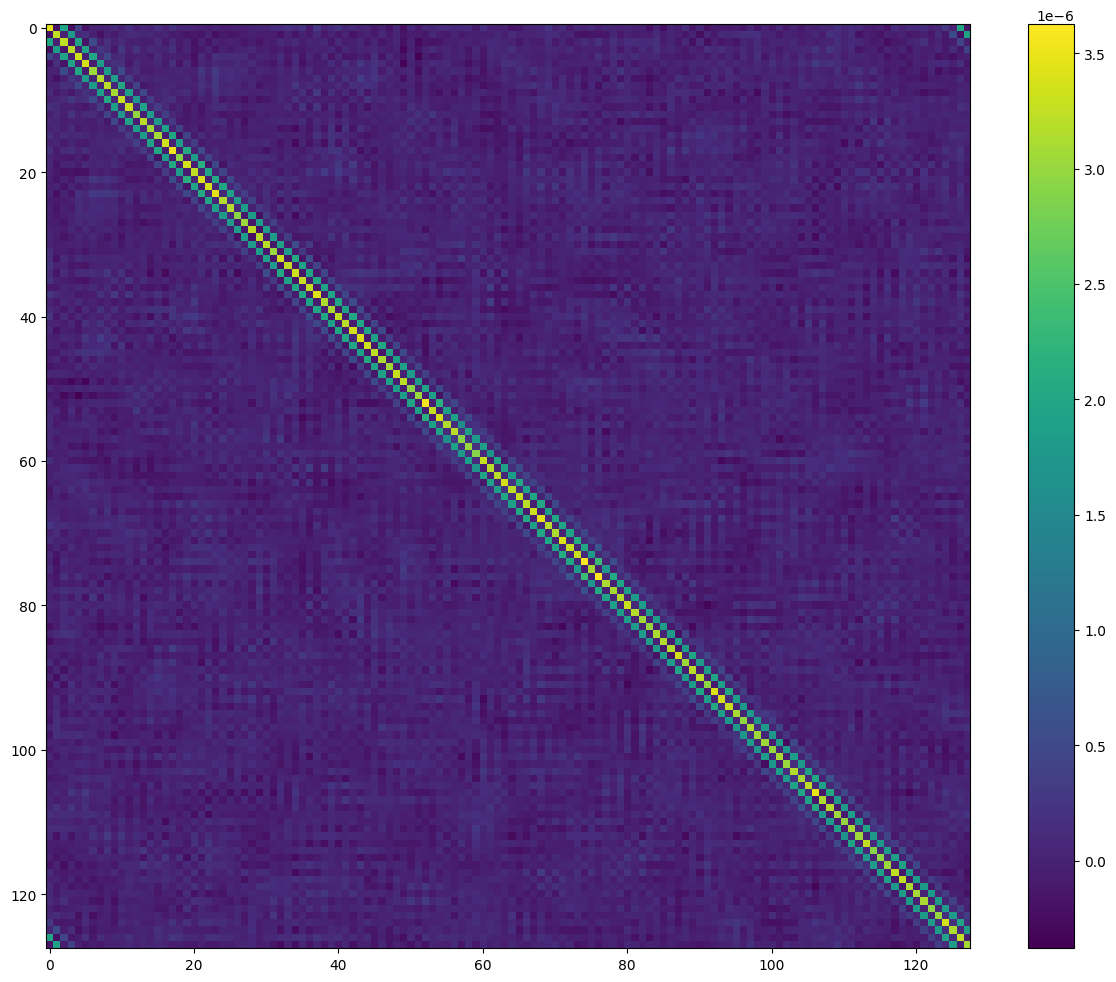

In [286]:
cov_matrix = jnp.cov(disps, rowvar=False)
plt.imshow(cov_matrix)
plt.colorbar()

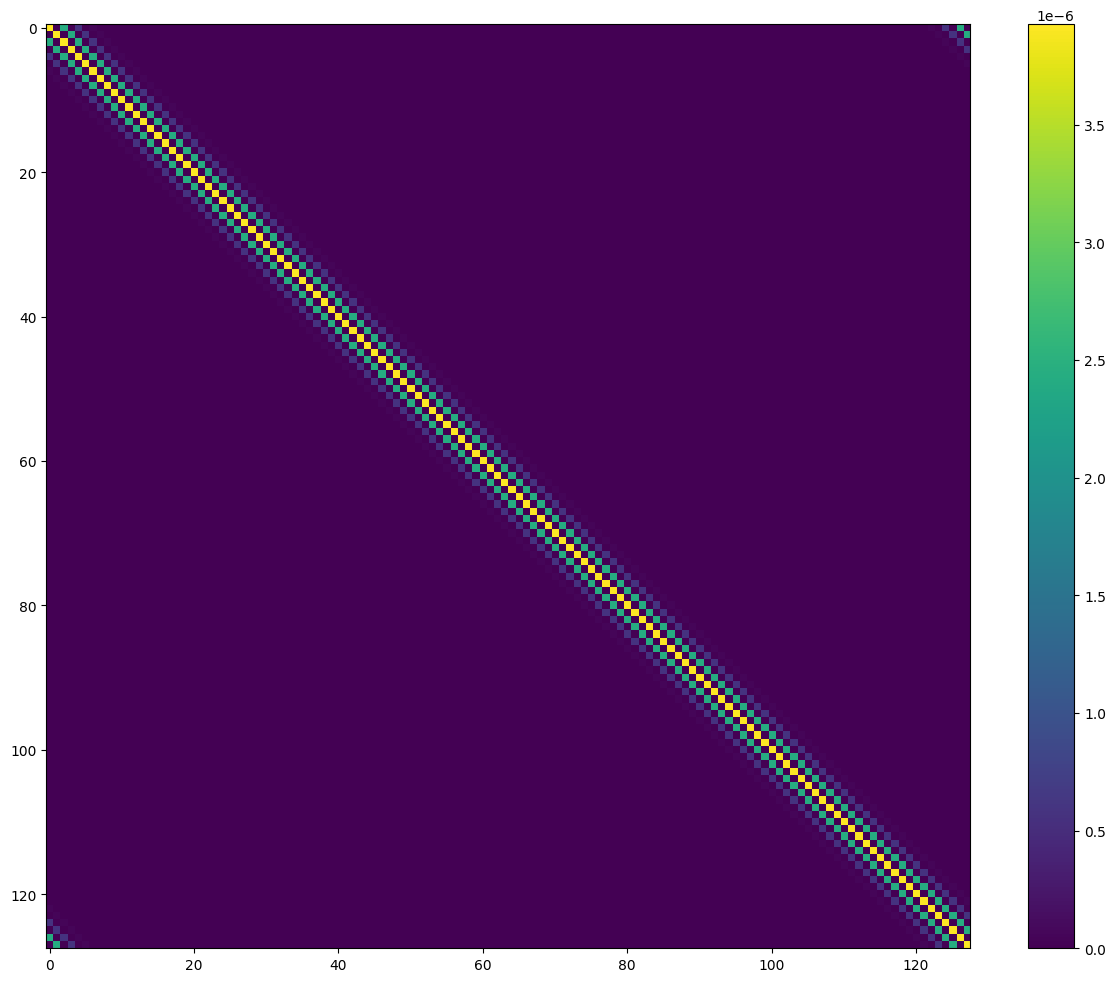

In [287]:
plt.imshow(Q(q0[0], KERNEL_ALPHA, KERNEL_SIGMA) * (T / N_STEPS))
plt.colorbar()

In [100]:
def dW_covariance_estimation(kernel_amp_coords=1.0, kernel_scale_coords=0.1, sigma_deviation=3.0, coords_range=[-1.5, 1.5], dW_resolution=128):
    global key
    x_left, x_right = coords_range
    delta_p = (x_right - x_left) / dW_resolution 
    kernel_amp_pixels = kernel_amp_coords * delta_p
    kernel_scale_pixels = kernel_scale_coords / delta_p
    kernel_edge_pixels = kernel_scale_pixels * sigma_deviation
    kernel_dim_pixels = int(2 * kernel_edge_pixels) + 1
    kernel_span_pixels = jnp.linspace(-kernel_edge_pixels, kernel_edge_pixels, kernel_dim_pixels)
    print(f"kernel dim: {kernel_dim_pixels} x {kernel_dim_pixels}")

    # Empirical covariance of dW
    gaussian = lambda span, loc, scale: jnp.exp(-1.0 * ((span - loc) / scale)**2)
    gaussian_pixels = partial(gaussian, loc=0.)
    k_Q_half_pixels = lambda kernel_amp_pixels, kernel_scale_pixels: kernel_amp_pixels \
                                                                     * gaussian_pixels(span=kernel_span_pixels, scale=kernel_scale_pixels) \
                                                                     * gaussian_pixels(span=kernel_span_pixels[:, None], scale=kernel_scale_pixels)
    dW_pixels = lambda key: jax.random.normal(key, (dW_resolution, dW_resolution))
    Q_half_dW_pixels = lambda _dW_pixels, _Q_half_pixels: jsp.signal.convolve2d(_dW_pixels, _Q_half_pixels, mode='same')
    interpolate = lambda _Q_half_dW_pixels, x: jsp.ndimage.map_coordinates(_Q_half_dW_pixels.T, x.T, order=1)

    # Theoretical covariance of dW
    k_Q_pixels = lambda x, kernel_amp_pixels, kernel_scale_pixels: 0.5 * kernel_amp_pixels**2 * kernel_scale_pixels**2 * jnp.pi * jnp.exp(-0.5 / kernel_scale_pixels**2 * jnp.sum(jnp.square(x), 2)) 
    k_Q_coords = lambda q, kernel_amp_coords, kernel_scale_coords: 0.5 * kernel_amp_coords**2 * kernel_scale_coords**2 * jnp.pi * jnp.exp(-0.5 / kernel_scale_coords**2 * jnp.sum(jnp.square(q), 2)) 
    kQ_q_pixels = lambda x, kernel_amp_pixels, kernel_scale_pixels: k_Q_pixels(x[:, jnp.newaxis] - x[jnp.newaxis, :], kernel_amp_pixels, kernel_scale_pixels)
    kQ_q_coords = lambda q, kernel_amp_coords, kernel_scale_coords: k_Q_coords(q[:, jnp.newaxis] - q[jnp.newaxis, :], kernel_amp_coords, kernel_scale_coords)  

    _dWs = []
    _Q_half_dWs = []

    to_grid = lambda q: (q - x_left) / delta_p
    to_coords = lambda x: x * delta_p + x_left

    q = jnp.stack([jnp.cos(jnp.linspace(0., 2.0*jnp.pi, 64)), jnp.sin(jnp.linspace(0., 2.0*jnp.pi, 64))]).T
    x = to_grid(q)

    for i in range(1000):
        key, _ = jax.random.split(key)
        _dW = dW_pixels(key)
        _dWs.append(interpolate(_dW, x))
        _Q_half_dW = Q_half_dW_pixels(_dW, k_Q_half_pixels(kernel_amp_pixels, kernel_scale_pixels))
        _Q_half_dWs.append(interpolate(_Q_half_dW, x))

    fig, ax = plt.subplots(1, 4, figsize=(40, 10))
    im0 = ax[0].imshow(jnp.cov(jnp.stack(_dWs), rowvar=False))
    ax[0].set_title('Empirical Covariance of dW')
    plt.colorbar(im0, ax=ax[0])

    im1 = ax[1].imshow(jnp.cov(jnp.stack(_Q_half_dWs), rowvar=False))
    ax[1].set_title('Empirical Covariance of dW convolved')
    plt.colorbar(im1, ax=ax[1])

    im2 = ax[2].imshow(kQ_q_pixels(x.reshape((-1, 2)), kernel_amp_pixels, kernel_scale_pixels))
    ax[2].set_title('Q matrix grid')
    plt.colorbar(im2, ax=ax[2])

    im3 = ax[3].imshow(kQ_q_coords(q.reshape((-1, 2)), kernel_amp_coords, kernel_scale_coords))
    ax[3].set_title('Q matrix coords')
    plt.colorbar(im3, ax=ax[3])


kernel dim: 26 x 26


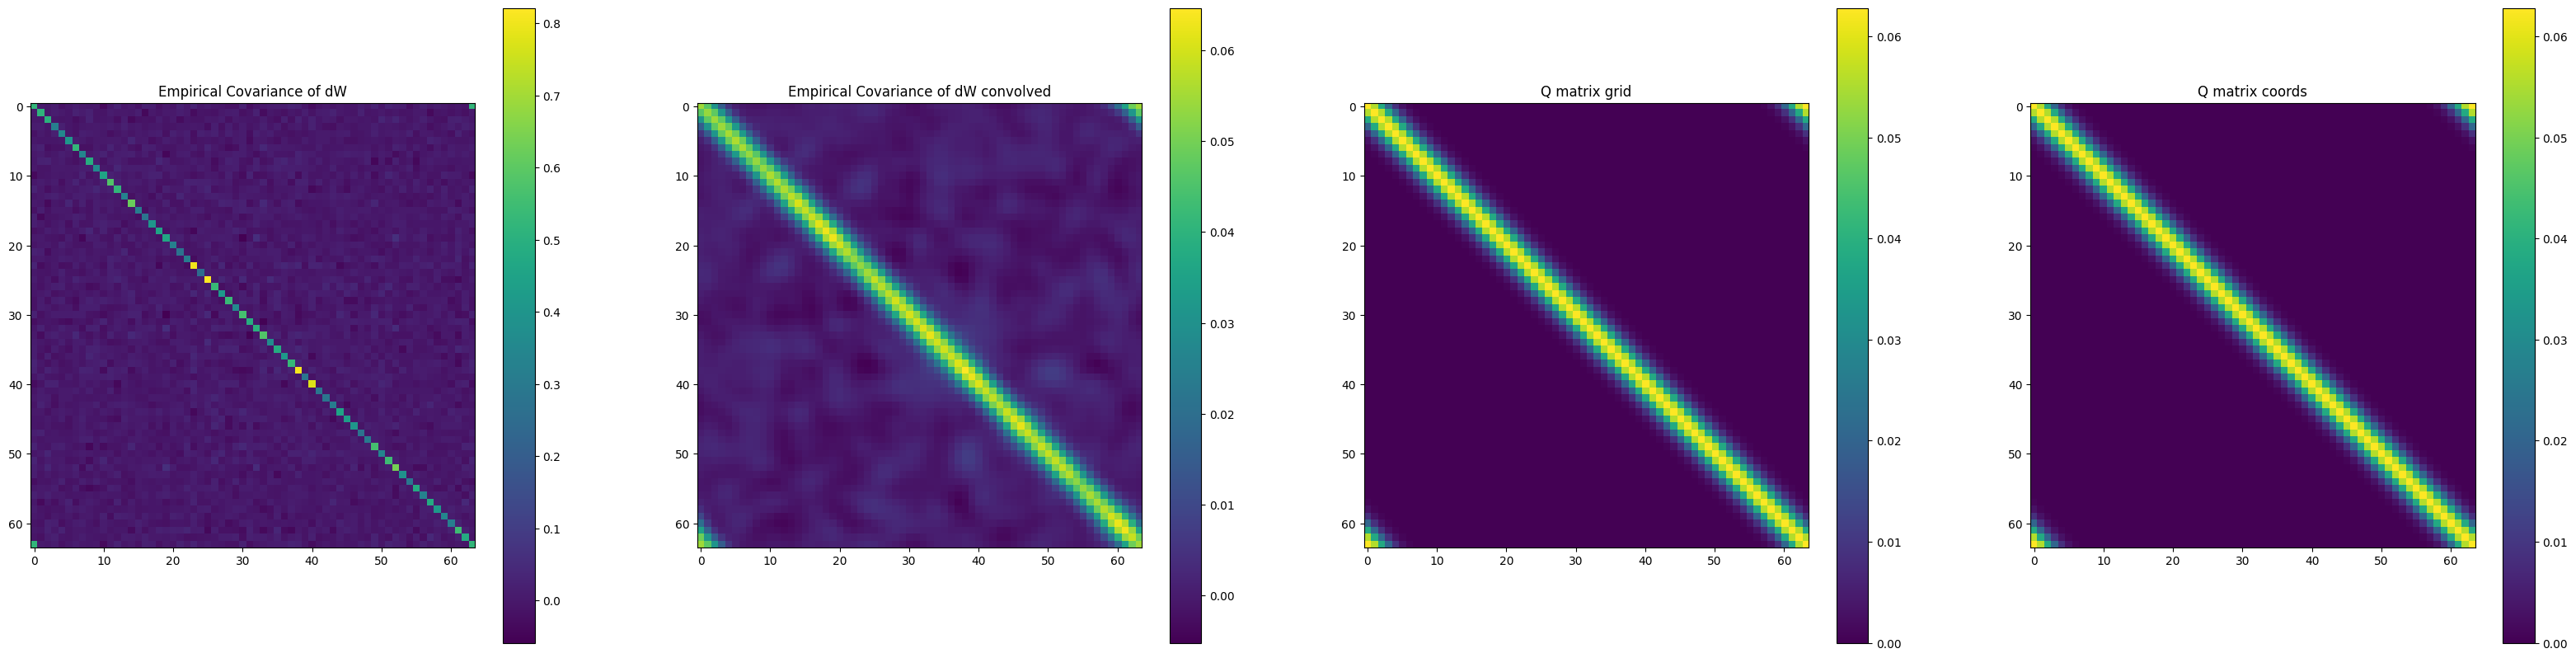

In [107]:
dW_covariance_estimation(kernel_scale_coords=0.2, dW_resolution=64)

kernel dim: 26 x 26


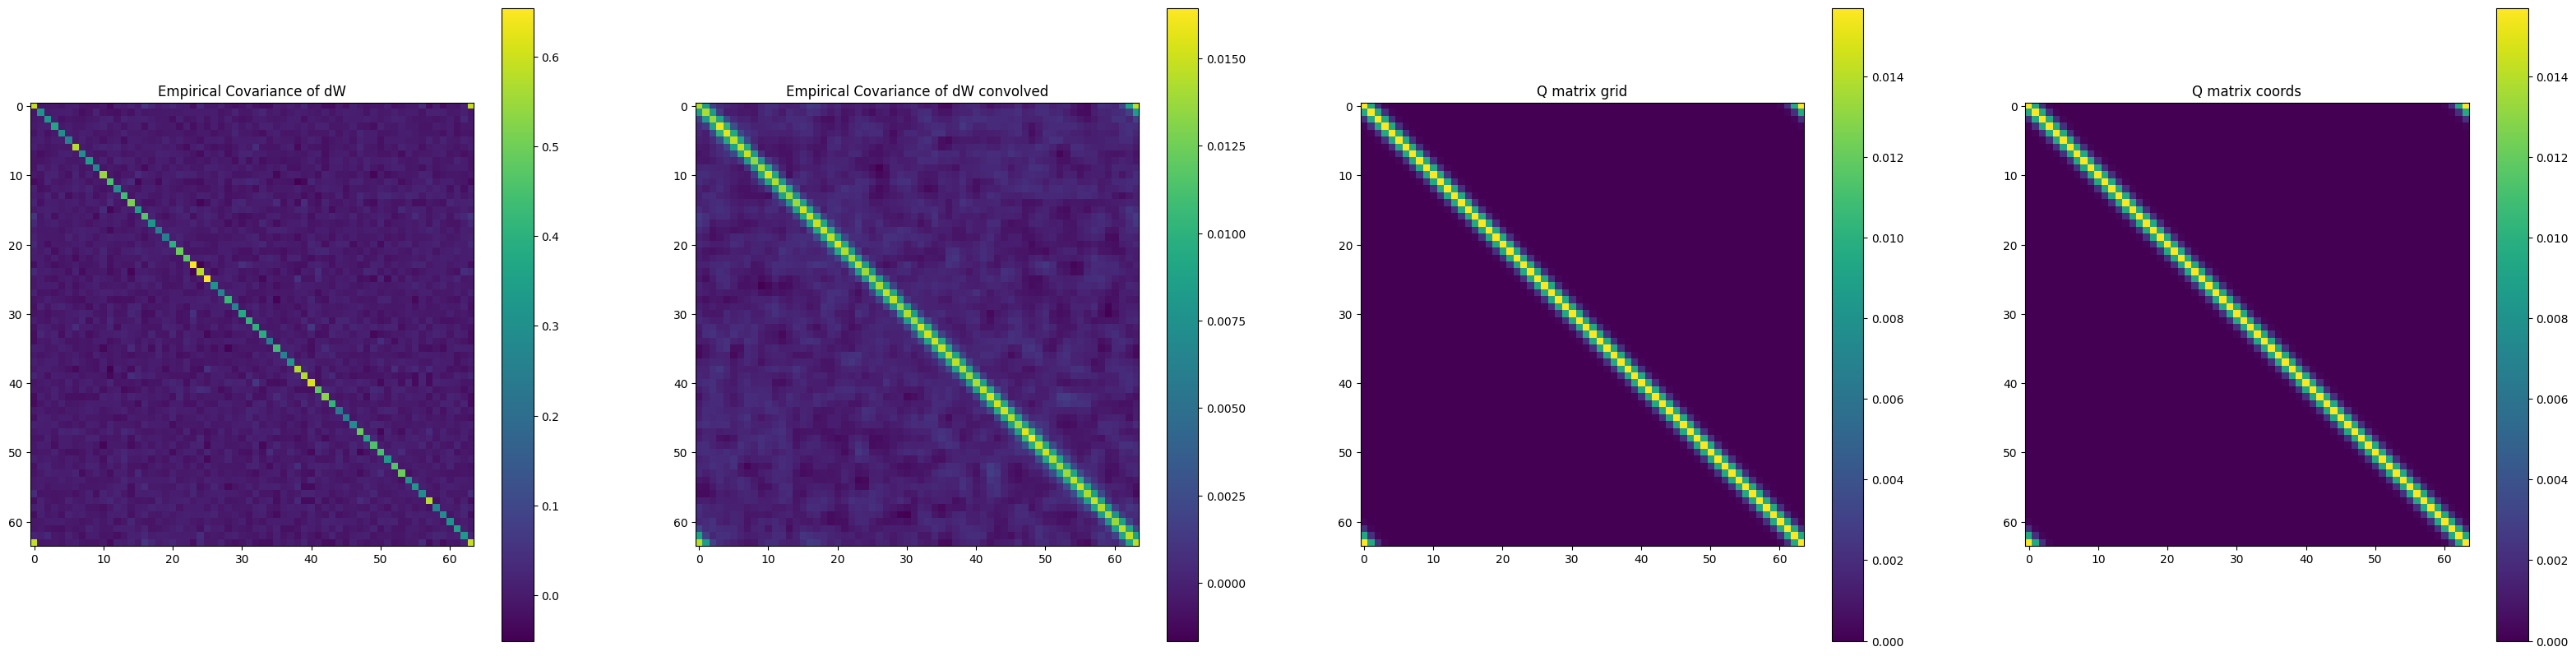

In [105]:
dW_covariance_estimation(kernel_scale_coords=0.1)

kernel dim: 129 x 129


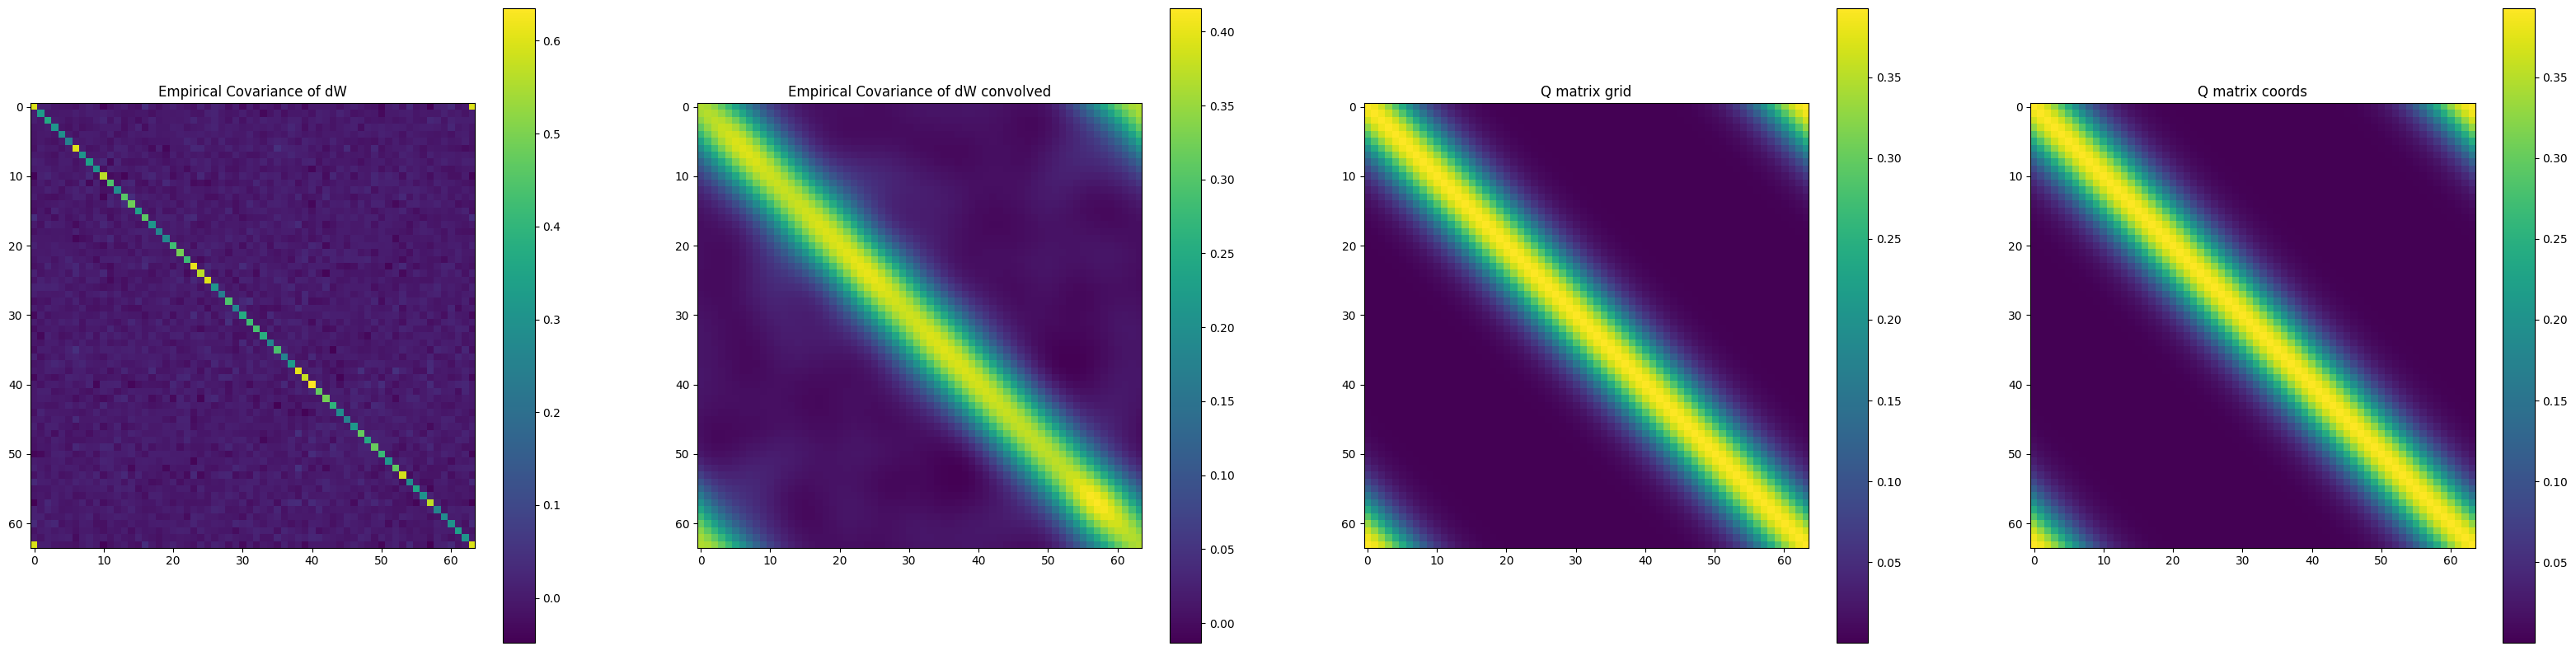

In [106]:
dW_covariance_estimation(kernel_scale_coords=0.5)

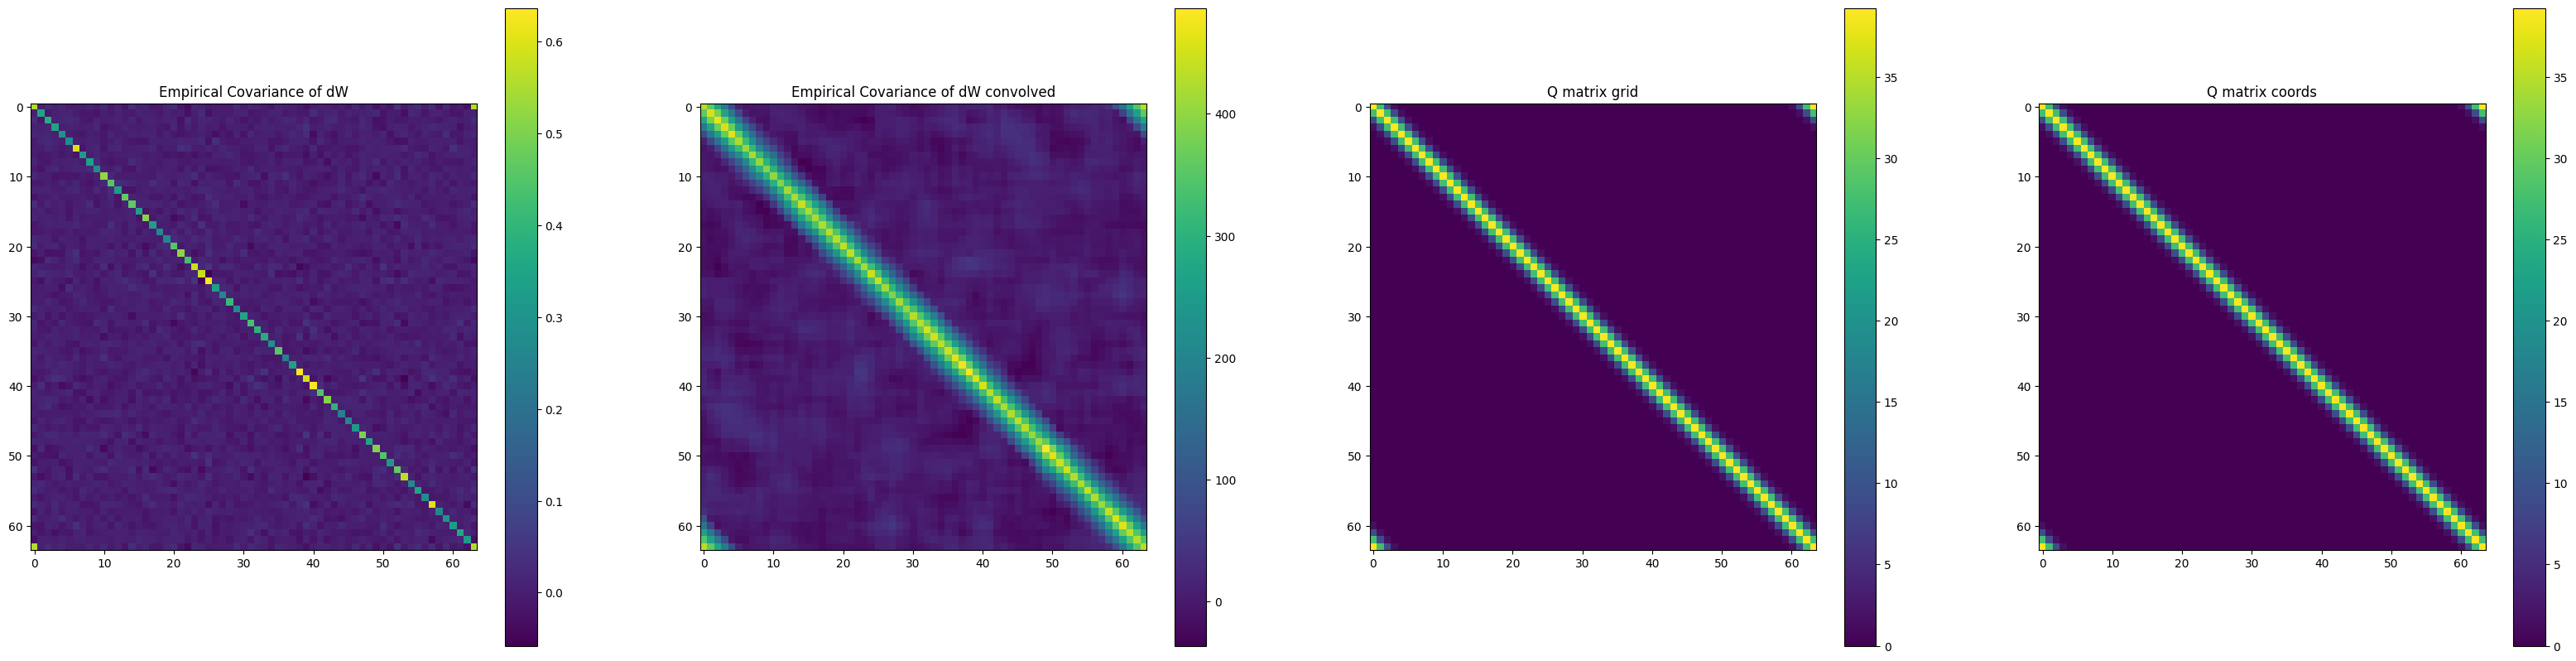

In [68]:
dW_covariance_estimation(21)

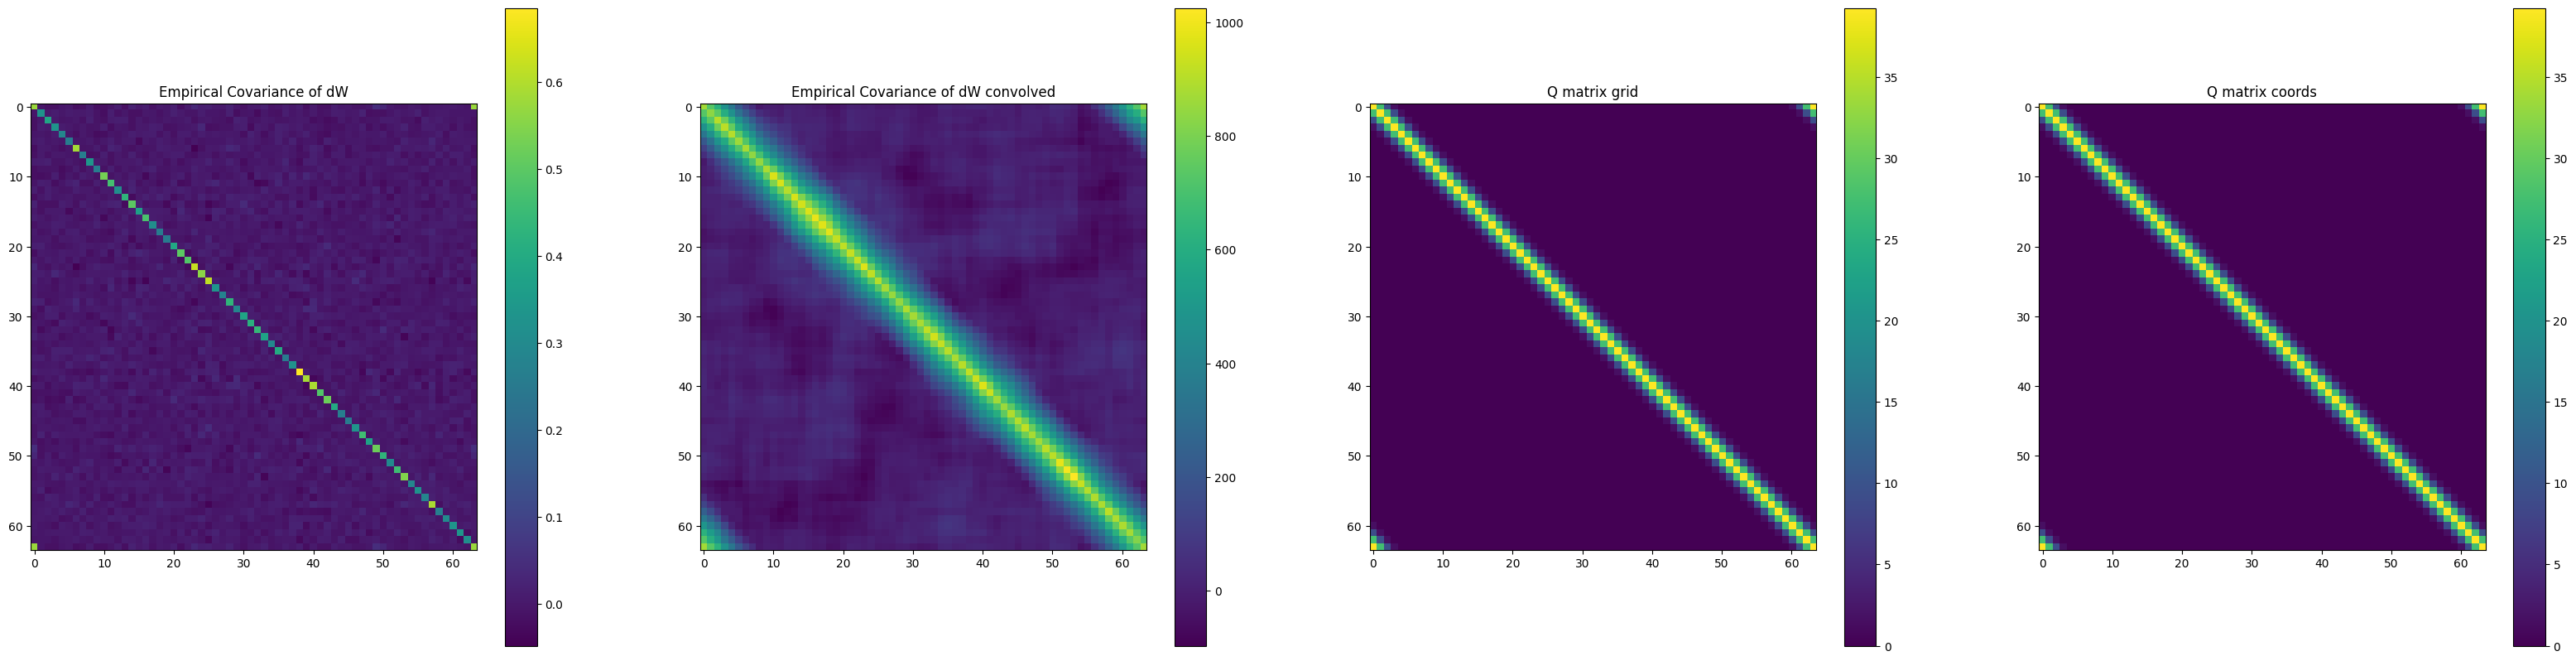

In [69]:
dW_covariance_estimation(31)